# Soils Revealed precalculations with `Zarrs`

<a id='libraries'></a>
### Python libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from affine import Affine
import xarray as xr
import dask.array as da
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler, visualize
from xhistogram.xarray import histogram
from rasterio import features
import zarr
import rioxarray
import regionmask
import gcsfs
import s3fs
from geocube.api.core import make_geocube
import shapely.wkb 
from shapely.ops import cascaded_union
import json
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from tqdm import tqdm
from ast import literal_eval

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
from pathlib import Path 
env_path = Path('.') / '.env'

In [3]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster(n_workers=1, threads_per_worker=36)
client = Client()  # start distributed scheduler locally.  Launch dashboard
client

Client Scheduler: tcp://scheduler:8786 Dashboard: http://scheduler:8787/status,Cluster Workers: 1 Cores: 48 Memory: 135.02 GB


<a id='utils'></a>
### Utils

**intersect_areas**

In [4]:
def intersect_areas(gdf, geometry):
    """
    Intersection between the areas of a GeoDataFrame and a geometry
    """
    sindex = gdf.sindex
    
    # Areas that intersect with the geometry
    possible_matches_index = list(sindex.intersection(geometry.bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    
    # Intersection between the areas and the geometry
    precise_matches = possible_matches.intersection(geometry)
    
    # Replace areas with the intersected ones
    final_matches = possible_matches[~precise_matches.is_empty]
    final_matches['geometry'] = list(precise_matches[~precise_matches.is_empty])
    
    return final_matches

**plot_hist**

In [5]:
def plot_hist(x_min, count):
    width = x_min[1]-x_min[0]
    width -= width/5.
    x_min += width/(5.*2)
    per = count/count.sum()*100
    
    plt.figure(figsize=(10,5))
    
    plt.bar(x_min, per, width=width)
    
    plt.plot([0,0], [0,per.max()], color = 'k', linestyle = '--')
    
    plt.title('Soil Organic Carbon Stock')
    plt.xlabel('SOC stock t C/ha)')
    plt.ylabel('(%) of total area')

**read_dataset_from_zarr**

In [6]:
def read_dataset_from_zarr(s3_path, group):
    # Initilize the S3 file system
    s3 = s3fs.S3FileSystem(key=os.getenv("S3_ACCESS_KEY_ID"), secret=os.getenv("S3_SECRET_ACCESS_KEY"))
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    # Read Zarr file
    ds = xr.open_zarr(store=store, group=group, consolidated=True)
    
    # Change coordinates names
    ds = ds.rename({'x': 'lon', 'y': 'lat'})
    
    # Change dimension name
    if group == 'concentration':
        ds = ds.rename({'depht': 'depth'})
    
    return ds

**prepare_vector_data**

In [7]:
def prepare_vector_data(iso=None, tolerance=None):
    if iso:
        bboxs = pd.read_csv('../data/mbtiles/country_bbox.csv', converters={"bbox": literal_eval})
        bbox = bboxs[bboxs['gid_0'] == iso].bbox.iloc[0]
    else:
        bbox = None
        
    # Read Political boundaries:
    print('Reading Political boundaries')
    gdf_pb = gpd.read_file('../data/mbtiles/gadm36_political_boundaries/gadm36_political_boundaries.shp', bbox = bbox)
    # Select up to level 1 admin areas
    gdf_pb = gdf_pb[gdf_pb['level'] <= 1]
    gdf_pb = gdf_pb[['name_0', 'gid_0', 'name_1', 'gid_1', 'level', 'geometry']]
    #Simplify geometries
    if tolerance:
        gdf_pb['geometry'] = gdf_pb['geometry'].apply(lambda x: x.simplify(tolerance)) 
        
    # Read Landforms
    print('Reading Landforms')
    gdf_land = gpd.read_file('../data/mbtiles/ne_10m_geography_regions_polys/ne_10m_geography_regions_polys.shp', bbox = bbox)
    gdf_land = gdf_land[['featurecla', 'name', 'region', 'ne_id', 'geometry']]
    
    # Read Biomes
    print('Reading Biomes')
    gdf_bio = gpd.read_file('../data/mbtiles/bio_042_ecoregions_by_biome_1_14/bio_042_ecoregions_by_biome_1_14.shp', bbox = bbox)
    gdf_bio.drop(columns='cartodb_id', inplace=True)
    
    # Read Hydrological basins
    print('Reading Hydrological basins')
    gdf_hb = gpd.read_file('../data/mbtiles/hydrological_basins/hydrological_basins.shp', bbox = bbox)
    #Make valid geometries
    gdf_hb['geometry'] = gdf_hb['geometry'].apply(lambda x: x.buffer(0))

    vector_data = {'political_boundaries': gdf_pb, 'landforms': gdf_land, 'biomes': gdf_bio, 'hydrological_basins': gdf_hb}
    
    if iso:
        print('Intersecting areas with the selected country')
        gdf_pb = gdf_pb[gdf_pb['gid_0'] == iso]
            
        vector_data['political_boundaries'] = gdf_pb
        
        country = gdf_pb[gdf_pb['level'] == 0]['geometry'].iloc[0].buffer(0)
        
        for data_name in list(vector_data.keys())[1:]:
            print(data_name)
            vector_data[data_name] = intersect_areas(vector_data[data_name], country)
            
    # Split DataFrames to avoid overlapping geometries
    split_df_by = ['level', 'featurecla', '', 'level']
    print("splitting DataFrames")
    for n, data_name in enumerate(list(vector_data.keys())):
        if split_df_by[n]:
            df = vector_data[data_name].copy()
            del vector_data[data_name]
            categories = list(df[split_df_by[n]].unique())
            for category in categories:
                vector_data[data_name+'_'+str(category)] = df[df[split_df_by[n]] == category]    
            
    # Set index
    for data_name in list(vector_data.keys()):
        vector_data[data_name] = vector_data[data_name].reset_index(drop=True).reset_index()
        
    ## Rename keys wiyh '/'
    #names = list(vector_data.keys())
    #for name in names:
    #    if '/' in name:
    #        vector_data[name.split('/')[0]] = vector_data.pop(name)
            
    return vector_data

**set_lat_lon_attrs**

In [8]:
def set_lat_lon_attrs(ds):
    """ Set CF latitude and longitude attributes"""
    ds["lon"] = ds.lon.assign_attrs({
      'axis' : 'X',
       'long_name' : 'longitude',
        'standard_name' : 'longitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_east',
            'valid_max' : 360.0,
             'valid_min' : -180.0
             })
    ds["lat"] = ds.lat.assign_attrs({
      'axis' : 'Y',
       'long_name' : 'latitude',
        'standard_name' : 'latitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_north',
            'valid_max' : 90.0,
             'valid_min' : -90.0
             })
    return ds

**create_ds_mask**

In [9]:
def create_ds_mask(df, ds, name, lon_name='lon', lat_name='lat'):
    # Create index column
    if 'index' not in df:
        df.reset_index(drop=True).reset_index()
    
    # Get mean ds cell area (in degrees) 
    mean_y_size = np.diff(ds.lat.values).mean()
    #print(mean_y_size)
    mean_x_size = np.diff(ds.lat.values).mean()
    #print(mean_x_size)
    mean_area = mean_y_size * mean_x_size
    print(f"The mean ds cell area is {np.round(mean_area, 6)} deg.\n")
    
    # Clip gdf to bounding box of ds
    xmin = ds.lon.min().values.tolist()
    xmax = ds.lon.max().values.tolist()
    ymin = ds.lat.min().values.tolist()
    ymax = ds.lat.max().values.tolist()
    df = df.cx[xmin:xmax, ymin:ymax]
    
    
    # Add area of geoms to gdf
    df = df.assign(area = df.area)
    df = df.assign(area_is_gt_cell = df['area'] > mean_area)
    print(f"Clipped gdf to dataset bounds, giving {len(df['index'])} potential geometries, of which {df['area_is_gt_cell'].sum()} are large enough.\n")
    
    print("Geometries smaller than mean cell size:")
    print(df.loc[df['area_is_gt_cell'] == False, ['index']])
    print("\n")

    # Extract indexes and geoms that are large enough!
    id_ints = df.loc[df['area_is_gt_cell'] == True, 'index'].values
    geoms = df.loc[df['area_is_gt_cell'] == True, 'geometry'].values
    
    print(f'Number of indexes: {len(id_ints)}')
    print(f'Number of geoms: {len(geoms)}')

    # create mask object
    da_mask = regionmask.Regions(
      name = name,
      numbers = id_ints,
      outlines = geoms)\
      .mask(ds, lon_name=lon_name, lat_name=lat_name)\
      .rename(name)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    
    print(f'Number of ints in mask: {len(id_ints_mask)}')
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask = set_lat_lon_attrs(da_mask)
    return da_mask

**`rasterio` and `geopandas` can be combined with `xarray` to make converting shapefiles into raster masks pretty easy.**

In [10]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='latitude', longitude='longitude',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

In [11]:
def create_ds_mask_rasterio(df, ds, name, lon_name='lon', lat_name='lat'):
    # Create index column
    if 'index' not in df:
        df.reset_index(drop=True).reset_index()
    
    # Get mean ds cell area (in degrees) 
    mean_y_size = np.diff(ds.lat.values).mean()
    #print(mean_y_size)
    mean_x_size = np.diff(ds.lat.values).mean()
    #print(mean_x_size)
    mean_area = mean_y_size * mean_x_size
    print(f"The mean ds cell area is {np.round(mean_area, 6)} deg.\n")
    
    # Clip gdf to bounding box of ds
    xmin = ds.lon.min().values.tolist()
    xmax = ds.lon.max().values.tolist()
    ymin = ds.lat.min().values.tolist()
    ymax = ds.lat.max().values.tolist()
    df = df.cx[xmin:xmax, ymin:ymax]
    
    
    # Add area of geoms to gdf
    df = df.assign(area = df.area)
    df = df.assign(area_is_gt_cell = df['area'] > mean_area)
    print(f"Clipped gdf to dataset bounds, giving {len(df['index'])} potential geometries, of which {df['area_is_gt_cell'].sum()} are large enough.\n")
    
    print("Geometries smaller than mean cell size:")
    print(df.loc[df['area_is_gt_cell'] == False, ['index']])
    print("\n")

    # Extract indexes and geoms that are large enough!
    id_ints = df.loc[df['area_is_gt_cell'] == True, 'index'].values
    geoms = df.loc[df['area_is_gt_cell'] == True, 'geometry'].values
    
    print(f'Number of indexes: {len(id_ints)}')
    print(f'Number of geoms: {len(geoms)}')
    
    # create mask object
    shapes = zip(df.geometry.buffer(0), range(len(df)))
    da_mask = rasterize(shapes, ds.coords, longitude=lon_name, latitude=lat_name).rename(name)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    
    print(f'Number of ints in mask: {len(id_ints_mask)}')
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask = set_lat_lon_attrs(da_mask)
    return da_mask

**precalculate_change**

In [371]:
def precalculate_change(df, xds, name, variable, group_type, nBinds=[40], bindsRange=[[-50, 50]]):
    indexes = xds[name].attrs.get('id_ints').astype(np.float32)
    times = xds.coords.get('time').values
    depths = xds.coords.get('depth').values
    
    Indexes = []
    Counts = []
    Bins = []
    Mean = []
    Depth = []
    Dates = []
    
    for index in tqdm(indexes):
        xmin, ymax, xmax, ymin = df.iloc[int(index)]['geometry'].bounds
        xds_index = xds.where(xds[name].isin(index)).sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax))
        for n, depth in enumerate(depths):
            try:
                start_date = times[0]
                end_date = times[-1]
                
                # Get difference between two dates
                diff = xds_index.loc[dict(time=end_date, depth=depth)] - xds_index.loc[dict(time=start_date, depth=depth)]
                
                # Get counts and binds of the histogram
                if variable == 'concentration':
                    diff = diff[variable]/10.
                else:
                    diff = diff[variable]
                
                if len(depths) == len(nBinds):
                    h, bins = da.histogram(diff, bins=nBinds[n], range=bindsRange[n])
                else:
                    h, bins = da.histogram(diff, bins=nBinds[0], range=bindsRange[0])
                
                # Compute change value
                if group_type == 'historic':
                    start_year = start_date
                    end_year = end_date
                else:
                    start_year = pd.to_datetime(start_date).year
                    end_year = pd.to_datetime(end_date).year
                    
                mean_diff = diff.mean(skipna=True).values   
                
                # Save values
                Indexes.append(int(index))
                Counts.append(h.compute())
                Bins.append(bins)
                Mean.append(mean_diff)
                Depth.append(depth)
                Dates.append([start_year, end_year])

            except:
                pass
            
    df_change = pd.DataFrame({"index": Indexes, "counts": Counts, "bins": Bins, "mean_diff":Mean, "depth": Depth, "years": Dates})
                  
    return pd.merge(df.drop(columns='geometry'), 
                    df_change, 
                    how='left', 
                    on='index')

**precalculate_change_all_years**

In [13]:
def precalculate_change_all_years(df, xds, name, file_path, nBinds=40, bindsRange=[-50, 50]):
    indexes = xds[name].attrs.get('id_ints').astype(np.float32)
    times = xds.coords.get('time').values
    depths = xds.coords.get('depth').values
    
    if os.path.isfile(file_path):
        os.remove(file_path)
    
    store = pd.HDFStore(file_path)
    
    for index in tqdm(indexes):
        xmin, ymax, xmax, ymin = df.iloc[int(index)]['geometry'].bounds
        xds_index = xds.where(xds[name].isin(index)).sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax))
        for depth in depths:
            for i in range(len(times)):
                for j in range(len(times)-1-i):
                    try:
                        start_date = times[i]
                        end_date = times[i+j+1]
                        
                        # Get difference between two dates
                        diff = xds_index.loc[dict(time=end_date, depth=depth)] - xds_index.loc[dict(time=start_date, depth=depth)]
                        
                        # Get counts and binds of the histogram
                        h, bins = da.histogram(diff.stocks, bins=nBinds, range=bindsRange)
                        
                        # Compute change value
                        start_year = pd.to_datetime(start_date).year
                        end_year = pd.to_datetime(end_date).year
                        mean_diff = diff.stocks.mean(skipna=True).values                  
        
                        df_row = pd.DataFrame({"index": int(index), "counts": str(h.compute()), "bins": str(bins), "mean_diff":mean_diff, "depth": depth, "years": str([start_year, end_year])}, index=[int(index)])
    
                        df_row.to_hdf(file_path, 'table', append=True, min_itemsize={"counts": 500,"bins":500, "years":100})
        
                    except:
                        pass
                          
    store.close()

**precalculate_time_series**

In [273]:
def precalculate_time_series(df, xds, name, variable, group):
    indexes = xds[name].attrs.get('id_ints').astype(np.float32)
    depths = xds.coords.get('depth').values

    if group == 'historic':
        years = xds.coords.get('time').values
    else:
        years = list(pd.DatetimeIndex(xds.coords.get('time').values).year)
    
    Indexes = []
    Value = []
    Depth = []
    Years = []
    
    for index in tqdm(indexes):
        xmin, ymax, xmax, ymin = df.iloc[int(index)]['geometry'].bounds
        xds_index = xds.where(xds[name].isin(index)).sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax))
        for depth in depths:
            try:
                if variable == 'concentration':
                    xds_var = xds_index[variable]/10.
                else:
                    xds_var = xds_index[variable]
                    
                # Get mean values
                value = xds_var.sel(depth=depth).mean(['lon', 'lat']).values
               
                # Save values
                Indexes.append(int(index))
                Value.append(value)
                Depth.append(depth)  
                Years.append(years)
                
            except:
                pass
            
    df_mean = pd.DataFrame({"index": Indexes, "mean_values":Value, "depth": Depth, 'years': Years})
    
    return pd.merge(df.drop(columns='geometry'), 
                    df_mean, 
                    how='left', 
                    on='index')

**save_precalculations**

In [15]:
def save_precalculations(vector_data, variable = 'stocks', group_type='experimental_dataset', output_type = 'change', root_path = '../data/precalculations/'):
    final_table_names = {'biomes': [], 
     'political_boundaries': ['political_boundaries_1', 'political_boundaries_0'],
     'landforms': ['landforms_Range/mtn', 'landforms_Geoarea', 'landforms_Island', 'landforms_Plateau', 'landforms_Pen/cape', 'landforms_Plain', 'landforms_Wetlands', 'landforms_Continent'],
     'hydrological_basins': ['hydrological_basins_1', 'hydrological_basins_0']}
    
    for name in final_table_names.keys():
        if not final_table_names[name]:
            df = vector_data[name].drop(columns='index')
        else:
            for n, old_name in enumerate(final_table_names[name]):
                if n == 0:
                    df = pd.DataFrame(columns=vector_data[old_name].columns)
                df = pd.concat([df, vector_data[old_name]])
                df.drop(columns='index', inplace=True)
                
        df['variable'] = variable
        df['group_type'] = group_type
        
        df.to_csv(root_path+name+'_'+group_type+'_'+variable+'_'+output_type+'.csv')

## Read `xarray.Dataset` from `Zarr` in Amazon S3 bucket

In [86]:
s3_path = 's3://soils-revealed/global-dataset.zarr' #'s3://soils-revealed/experimental-dataset.zarr' 
group = 'historic'#'concentration' #stocks
ds = read_dataset_from_zarr(s3_path, group)
ds

,Array,Chunk
Bytes,447.90 MB,1.17 MB
Shape,"(3, 2, 2160, 4320)","(1, 1, 270, 540)"
Count,385 Tasks,384 Chunks
Type,float64,numpy.ndarray


## Read vector data

In [87]:
vector_data = prepare_vector_data(iso=None, tolerance=0.075)

Reading Political boundaries
Reading Landforms
Reading Biomes
Reading Hydrological basins
splitting DataFrames


## Zonal statistics

**Create the data mask by rasterizing the vector data**

In [259]:
names = list(vector_data.keys())
names.remove('landforms_Dragons-be-here')
for name in names:
    print(f'Create the data mask for {name}:')
    da_mask = create_ds_mask(vector_data[name], ds, name, lon_name='lon', lat_name='lat')
    
    ds[name] = da_mask

Create the data mask for biomes:
The mean ds cell area is 0.006944 deg.

Clipped gdf to dataset bounds, giving 2664 potential geometries, of which 1033 are large enough.

Geometries smaller than mean cell size:
      index
77       77
157     157
163     163
217     217
278     278
...     ...
2665   2665
2666   2666
2667   2667
2668   2668
2669   2669

[1631 rows x 1 columns]


Number of indexes: 1033
Number of geoms: 1033
Number of ints in mask: 1018
Create the data mask for political_boundaries_1:
The mean ds cell area is 0.006944 deg.

Clipped gdf to dataset bounds, giving 3610 potential geometries, of which 3203 are large enough.

Geometries smaller than mean cell size:
      index
34       34
57       57
230     230
232     232
236     236
...     ...
3582   3582
3589   3589
3592   3592
3600   3600
3603   3603

[407 rows x 1 columns]


Number of indexes: 3203
Number of geoms: 3203
Number of ints in mask: 3186
Create the data mask for political_boundaries_0:
The mean ds cell area 

In [92]:
ds

,Array,Chunk
Bytes,447.90 MB,1.17 MB
Shape,"(3, 2, 2160, 4320)","(1, 1, 270, 540)"
Count,385 Tasks,384 Chunks
Type,float64,numpy.ndarray


### Histogram
#### **Example**
Select subsample:

In [224]:
ds_eg = ds.isel(time=[0,1]).copy()

In [225]:
indexes = ds_eg.political_boundaries_0.attrs.get('id_ints').astype(np.float32)
times = ds_eg.coords.get('time').values
depths = ds_eg.coords.get('depth').values

In [237]:
df = vector_data['political_boundaries_0'].copy()
index = 235
xmin, ymax, xmax, ymin = df.iloc[index]['geometry'].bounds
ds_index = ds_eg.where(ds_eg['political_boundaries_0'].isin(index)).sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax)).copy()

diff = ds_index.loc[dict(time=times[1], depth=depths[2])] - ds_index.loc[dict(time=times[0], depth=depths[2])]
diff

<xarray.Dataset>
Dimensions:                 (lat: 193, lon: 270)
Coordinates:
    depth                   <U5 '0-200'
  * lon                     (lon) float64 -18.13 -18.04 -17.96 ... 4.208 4.292
  * lat                     (lat) float64 43.71 43.63 43.54 ... 27.79 27.71
Data variables:
    stocks                  (lat, lon) float64 dask.array<chunksize=(193, 218), meta=np.ndarray>
    biomes                  (lat, lon) float64 nan nan nan nan ... nan nan nan
    political_boundaries_1  (lat, lon) float64 nan nan nan nan ... nan nan nan
    political_boundaries_0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Island        (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Island group  (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Coast         (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Range/mtn     (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Pen/cape      (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Desert        (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Plateau       (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Geoarea       (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Plain         (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Depression    (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Valley        (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Wetlands      (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Delta         (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Basin         (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Lowland       (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Gorge         (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Tundra        (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Isthmus       (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Foothills     (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Continent     (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Peninsula     (lat, lon) float64 nan nan nan nan ... nan nan nan

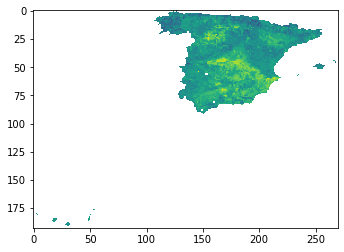

In [238]:
plt.imshow(diff.stocks.values)

**with `xhistogram`**

In [239]:
bins = np.linspace(-60, 60, 61)
h = histogram(diff.stocks, bins=[bins], dim=['lat', 'lon'])
h

<xarray.DataArray 'histogram_stocks' (stocks_bin: 60)>
dask.array<getitem, shape=(60,), dtype=int64, chunksize=(60,), chunktype=numpy.ndarray>
Coordinates:
  * stocks_bin  (stocks_bin) float64 -59.0 -57.0 -55.0 -53.0 ... 55.0 57.0 59.0

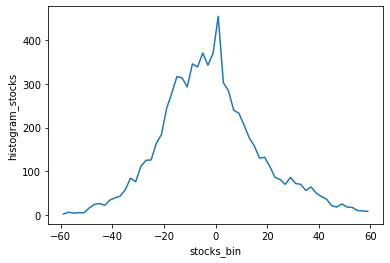

In [240]:
with ProgressBar():
    h.plot()

Plot change distribution

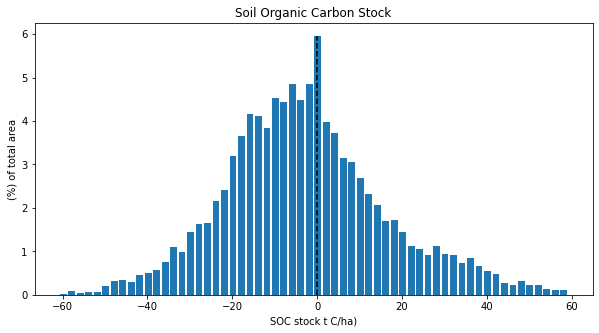

In [241]:
with ProgressBar():
    count = h.values
    
x_min = bins[:-1]
plot_hist(x_min, count)

**with `da.histogram`**

In [249]:
h, bins = da.histogram(diff.stocks, bins=60, range=[-60, 60])

Plot change distribution

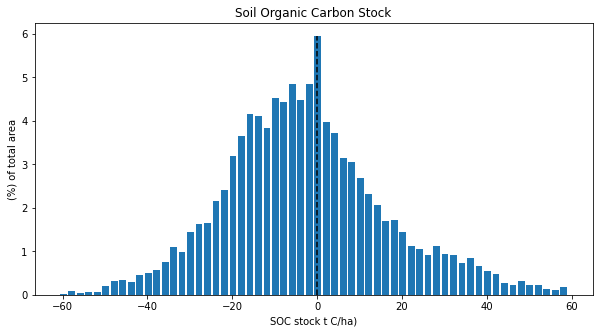

In [250]:
with ProgressBar():
    count = h.compute()

x_min = bins[:-1]
plot_hist(x_min, count)

**Display change value**

In [ ]:
years = pd.to_datetime(times[1]).year - pd.to_datetime(times[0]).year
mean_diff = diff.stocks.mean(skipna=True).compute().values
change = mean_diff/years

In [ ]:
print(f'Soil Organic Carbon Stock Change: {change} t C/ha year')

#### **Entire` DataFrame`**

In [ ]:
%%time
vector_data_new = {}
for name in list(vector_data.keys()):
    print(f'Precalculating change for {name}:')
    df = vector_data[name].copy()
    vector_data_new[name] = precalculate_change(df, ds, name, variable='stocks', nBinds=80, bindsRange=[-50, 50])

save_precalculations(vector_data_new, variable = 'stocks', group_type='experimental_dataset', output_type = 'change', root_path = '../data/precalculations/')

**Plot change distribution**

In [ ]:
df = vector_data_new['political_boundaries_1'].copy()
index = 10
count = df['counts'].iloc[index].copy()
bins = df['bins'].iloc[index].copy()
mean_diff = df['mean_diff'].iloc[index].copy()
years = df['years'].iloc[index].copy()
x_min = bins[:-1]
per = count/count.sum()*100
print(f'Soil Organic Carbon Stock Change: {mean_diff/(years[1]-years[0])} t C/ha year')
plot_hist(x_min, count)

### Mean value
#### **Example**

In [ ]:
vector_data['biomes'].iloc[14].geometry 

In [ ]:
index = 14
xmin, ymax, xmax, ymin = vector_data['biomes'].iloc[index]['geometry'].bounds

(ds.stocks
 .isel(time=slice(8,20))
 .where(ds['biomes'] == index)
 .sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax))
 .plot.imshow(col='time', col_wrap=4))

In [ ]:
ds.stocks.where(ds['biomes'] == index).sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax)).mean(['lon', 'lat']).plot()

#### **Entire` DataFrame`**

In [ ]:
%%time
vector_data_new = {}
for name in list(vector_data.keys()):
    print(f'Precalculating mean values for {name}:')
    df = vector_data[name].copy()
    vector_data_new[name] = precalculate_time_series(df, ds, name, variable='stocks')
    
save_precalculations(vector_data_new, variable = 'stocks', group_type='experimental_dataset', output_type = 'time_series', root_path = '../data/precalculations/')

**Plot time series**

In [ ]:
df = vector_data_new['political_boundaries_1'].copy()
index = 10
mean_values = df['mean_values'].iloc[index].copy()
years = df['years'].iloc[index].copy()
plt.plot(years, mean_values)

**Using `groupby`**

In [ ]:
%%time
grouped_xds = ds.groupby(ds['landforms_Plateau'])
grid_mean = grouped_xds.mean().rename({"stocks": "mean"})
grid_mean.to_dataframe()

## All the computational process at once
**Input variables**

In [375]:
s3_path = 's3://soils-revealed/global-dataset.zarr' #'s3://soils-revealed/experimental-dataset.zarr' 
group = 'historic'#'concentration'#stocks
variable = 'stocks'#'concentration'#stocks
iso = None#'ARG'
tolerance = 0.075
group_type = 'historic' #'experimental_dataset'
nBinds = [40, 40, 60]#[80]#[80]
bindsRange = [[-20,20], [-40,40], [-60,60]] #[[-10, 10]]#[[-50, 50]]

**Computation**

In [377]:
# Read xarray.Dataset from Zarr
print('Reading  xarray.Dataset.')
ds = read_dataset_from_zarr(s3_path, group)

# Read vector data
print('Reading  vector data.')
vector_data = prepare_vector_data(iso=iso, tolerance=tolerance)

# Create the data mask by rasterizing the vector data
print('Rasterizing the vector data.')
names = list(vector_data.keys())
names.remove('landforms_Dragons-be-here')
for name in names:
    print(f'Create the data mask for {name}:')
    da_mask = create_ds_mask(vector_data[name], ds, name, lon_name='lon', lat_name='lat')
    
    ds[name] = da_mask
    
# Precalculate change distribution
print('Precalculating change distribution.')
vector_data_new = {}
for name in names:
    print(f'Precalculating change for {name}:')
    df = vector_data[name].copy()
    vector_data_new[name] = precalculate_change(df, ds, name, variable=variable, group_type=group_type, nBinds=nBinds, bindsRange=bindsRange)

save_precalculations(vector_data_new, variable = variable, group_type=group_type, output_type = 'change', root_path = '../data/precalculations/')

## Precalculate time series
#print('Precalculating time series.')
#vector_data_new = {}
#for name in names:
#    print(f'Precalculating mean values for {name}:')
#    df = vector_data[name].copy()
#    vector_data_new[name] = precalculate_time_series(df, ds, name, variable=variable, group=group)
#    
#save_precalculations(vector_data_new, variable = variable, group_type=group_type, output_type = 'time_series', root_path = '../data/precalculations/')

Reading  xarray.Dataset.
Reading  vector data.
Reading Political boundaries
Reading Landforms
Reading Biomes
Reading Hydrological basins
splitting DataFrames
Rasterizing the vector data.
Create the data mask for biomes:
The mean ds cell area is 0.006944 deg.

Clipped gdf to dataset bounds, giving 2664 potential geometries, of which 1033 are large enough.

Geometries smaller than mean cell size:
      index
77       77
157     157
163     163
217     217
278     278
...     ...
2665   2665
2666   2666
2667   2667
2668   2668
2669   2669

[1631 rows x 1 columns]


Number of indexes: 1033
Number of geoms: 1033
Number of ints in mask: 1018
Create the data mask for political_boundaries_1:
The mean ds cell area is 0.006944 deg.

Clipped gdf to dataset bounds, giving 3610 potential geometries, of which 3203 are large enough.

Geometries smaller than mean cell size:
      index
34       34
57       57
230     230
232     232
236     236
...     ...
3582   3582
3589   3589
3592   3592
3600   36

  0%|          | 0/1018 [00:00<?, ?it/s]

Number of ints in mask: 8929
Precalculating change distribution.
Precalculating change for biomes:


  0%|          | 0/3186 [00:00<?, ?it/s]

Precalculating change for political_boundaries_1:


  0%|          | 0/233 [00:00<?, ?it/s]

Precalculating change for political_boundaries_0:


  0%|          | 0/252 [00:00<?, ?it/s]

Precalculating change for landforms_Island:


  0%|          | 0/77 [00:00<?, ?it/s]

Precalculating change for landforms_Island group:


  0%|          | 0/37 [00:00<?, ?it/s]

Precalculating change for landforms_Coast:


  0%|          | 0/205 [00:00<?, ?it/s]

Precalculating change for landforms_Range/mtn:


  0%|          | 0/57 [00:00<?, ?it/s]

Precalculating change for landforms_Pen/cape:


  0%|          | 0/40 [00:00<?, ?it/s]

Precalculating change for landforms_Desert:


  0%|          | 0/64 [00:00<?, ?it/s]

Precalculating change for landforms_Plateau:


  0%|          | 0/42 [00:00<?, ?it/s]

Precalculating change for landforms_Geoarea:


  0%|          | 0/28 [00:00<?, ?it/s]

Precalculating change for landforms_Plain:


  0%|          | 0/2 [00:00<?, ?it/s]

Precalculating change for landforms_Depression:


  0%|          | 0/6 [00:00<?, ?it/s]

Precalculating change for landforms_Valley:


  0%|          | 0/3 [00:00<?, ?it/s]

Precalculating change for landforms_Wetlands:


  0%|          | 0/12 [00:00<?, ?it/s]

Precalculating change for landforms_Delta:


  0%|          | 0/9 [00:00<?, ?it/s]

Precalculating change for landforms_Basin:


  0%|          | 0/5 [00:00<?, ?it/s]

Precalculating change for landforms_Lowland:


  0%|          | 0/3 [00:00<?, ?it/s]

Precalculating change for landforms_Gorge:


  0%|          | 0/3 [00:00<?, ?it/s]

Precalculating change for landforms_Tundra:


  0%|          | 0/4 [00:00<?, ?it/s]

Precalculating change for landforms_Isthmus:


  0%|          | 0/3 [00:00<?, ?it/s]

Precalculating change for landforms_Foothills:


  0%|          | 0/7 [00:00<?, ?it/s]

Precalculating change for landforms_Continent:


  0%|          | 0/11 [00:00<?, ?it/s]

Precalculating change for landforms_Peninsula:


  0%|          | 0/3 [00:00<?, ?it/s]

Precalculating change for landforms_Lake:


  0%|          | 0/1899 [00:00<?, ?it/s]

Precalculating change for hydrological_basins_0:


 76%|███████▌  | 1437/1899 [1:00:05<18:33,  2.41s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Merge datasets

In [383]:
dir_path = '../data/precalculations/'
file_list = os.listdir(dir_path)
groups = ['biomes', 'hydrological_basins', 'landforms', 'political_boundaries']
subgroups = ['change', 'time_series']
for group in groups:
    group_list = [s for s in file_list if group in s]
    for subgroup in subgroups:
        sub_list = [s for s in group_list if subgroup in s]
        for n, file in enumerate(sub_list):
            if n == 0:
                df = pd.read_csv(dir_path+file, index_col=[0])
                if 'stocks' in file: df.rename(columns={'group': 'group_type'}, inplace=True)
            else:
                df_new = pd.read_csv(dir_path+file, index_col=[0])
                if 'stocks' in file: df_new.rename(columns={'group': 'group_type'}, inplace=True)
                df = pd.concat([df, df_new])
                
        df.to_csv(dir_path+group+'_'+subgroup+'.csv', index=False)

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Upload precalculations to Carto

In [81]:
from carto.auth import APIKeyAuthClient
from carto.datasets import DatasetManager
import getpass

**Authentication**

In [83]:
carto_api_key = getpass.getpass('Carto API Key:')

Carto API Key: ········································


In [84]:
USR_BASE_URL = "https://35.233.41.65/user/skydipper/"
auth_client = APIKeyAuthClient(api_key=carto_api_key, base_url=USR_BASE_URL)

**Import local datasets into CARTO via the Import API**

In [85]:
# write here the path to a local file or remote URL
LOCAL_FILE_OR_URL = "../data/precalculations/biomes_change.csv"

dataset_manager = DatasetManager(auth_client)
dataset = dataset_manager.create(LOCAL_FILE_OR_URL)

CartoException: HTTPSConnectionPool(host='35.233.41.65', port=443): Max retries exceeded with url: /user/skydipper/api/v1/imports/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fbda0f9c730>: Failed to establish a new connection: [Errno 110] Connection timed out'))

In [ ]:
import requests

In [ ]:
query = "SELECT * FROM political_boundaries_time_series WHERE variable = 'stocks' AND depth = '0-30' AND group_type =  'experimental_dataset' AND gid_1 = 'ARG.20_1'"

In [ ]:
#urlCarto = f"https://skydipper.35.233.41.65/api/v2/sql"
urlCarto = f"http://35.233.41.65/user/skydipper/api/v2/sql"

sql = {"q": query}
r = requests.get(urlCarto, params=sql)

data = r.json()

In [ ]:
df = gpd.GeoDataFrame(data.get("rows"))

In [ ]:
df

In [ ]:
r.url